<a href="https://colab.research.google.com/github/astrrr/Image-Processing-Lab/blob/main/Activity5_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 5.1 Data Preparation



*   List all filename in face image path



In [159]:
filenames= glob.glob ('/content/drive/MyDrive/face_dataset/lfw/*/*')



*   # Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)




In [160]:
im_arr = []
for i in range(4000):
  img = image.load_img(filenames[i],target_size=(90,90),interpolation='nearest')
  
  #convert img to arr
  img = image.img_to_array(img)
  
  #normalizeed color img
  img = img/255

  all_imgs = im_arr.append(img)



*   convert to numpy array




In [161]:
all_imgs = np.array(im_arr)

In [162]:
all_imgs.shape

(4000, 90, 90, 3)

* split data into train and validation data

In [163]:
train_x, test_x = train_test_split(all_imgs, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

# 5.2 ADD NOISE



*   Add Noise




In [164]:
#noise_factor = scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
noise_factor = 0.5



*   กำหนด noise parameter




In [165]:
noise_dist = 'nomal'
Nmean = 0
Nstd = 1

In [166]:
# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))
x_test_noisy = test_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))

plot noise picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


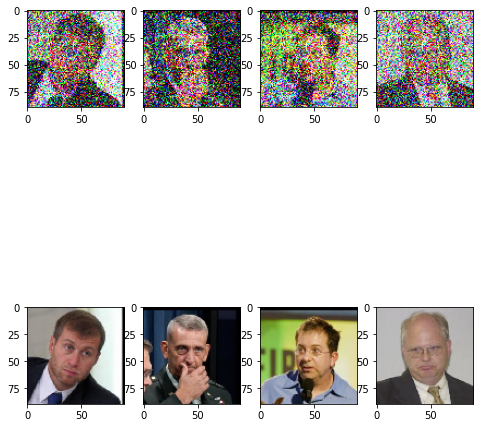

In [167]:
fig = plt.figure(figsize=(8,10))

fig.add_subplot(2,4,1)
plt.imshow(x_train_noisy[0])

fig.add_subplot(2,4,2)
plt.imshow(x_train_noisy[1])

fig.add_subplot(2,4,3)
plt.imshow(x_train_noisy[2])

fig.add_subplot(2,4,4)
plt.imshow(x_train_noisy[3])

fig.add_subplot(2,4,5)
plt.imshow(train_x[0])

fig.add_subplot(2,4,6)
plt.imshow(train_x[1])

fig.add_subplot(2,4,7)
plt.imshow(train_x[2])

fig.add_subplot(2,4,8)
plt.imshow(train_x[3])
plt.show()

# 5.3 AUTOENCODER MODEL



*   กำหนด Encoder Architecture




In [168]:
input_img = Input(shape=(90, 90, 3))



*   encoding architecture



In [169]:
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)



*   กำหนด Decoder Architecture




In [170]:
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
decoded = Conv2D(3, (3, 3), padding='same')(x5)



*   กำหนด optimizer setting



In [171]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse') #using mean square error
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 90, 90, 256)       7168      
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_30 (Conv2D)          (None, 45, 45, 64)        73792     
                                                                 
 conv2d_31 (Conv2D)          (None, 45, 45, 64)        36928     
                                                           

# 5.3 Training Autoencoder Model

In [172]:
history = autoencoder.fit (x_train_noisy, train_x,
  epochs=26,
  batch_size=32,
  shuffle=True,
  validation_data=(x_val_noisy, val_x),
  callbacks=[EarlyStopping()]) #

Epoch 1/26
62/62 [==============================] - 8s 113ms/step - loss: 0.0353 - val_loss: 0.0138
Epoch 2/26
62/62 [==============================] - 7s 110ms/step - loss: 0.0139 - val_loss: 0.0116


* ทดสอบ autoencoder model ด้วย validation

In [173]:
predictions = autoencoder.predict(x_val_noisy)
predictions = autoencoder.predict(x_test_noisy)



*   View Loss from history



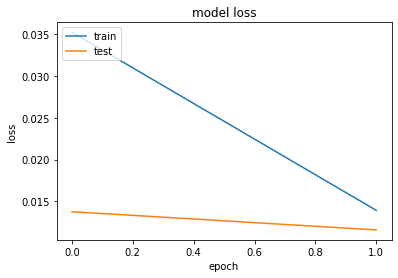

In [174]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



*   Display Result image



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


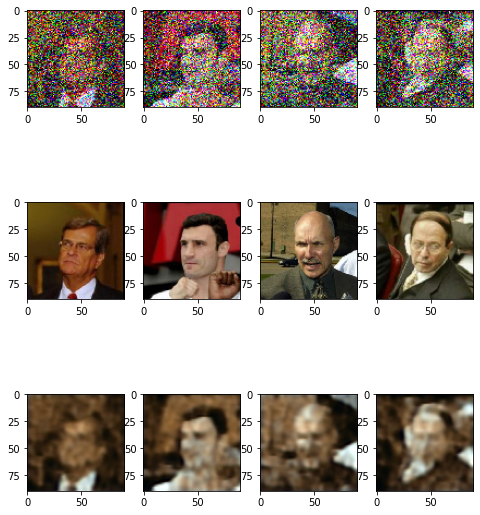

In [176]:
fig = plt.figure(figsize=(8,10))

fig.add_subplot(3,4,1)
plt.imshow(x_test_noisy[0])

fig.add_subplot(3,4,2)
plt.imshow(x_test_noisy[1])

fig.add_subplot(3,4,3)
plt.imshow(x_test_noisy[2])

fig.add_subplot(3,4,4)
plt.imshow(x_test_noisy[3])

fig.add_subplot(3,4,5)
plt.imshow(test_x[0])

fig.add_subplot(3,4,6)
plt.imshow(test_x[1])

fig.add_subplot(3,4,7)
plt.imshow(test_x[2])

fig.add_subplot(3,4,8)
plt.imshow(test_x[3])

fig.add_subplot(3,4,9)
plt.imshow(predictions[0])

fig.add_subplot(3,4,10)
plt.imshow(predictions[1])

fig.add_subplot(3,4,11)
plt.imshow(predictions[2])

fig.add_subplot(3,4,12)
plt.imshow(predictions[3])


plt.show()